# Modelo CatBoost: Encuesta Reddit Chile

## Conexión a fuente de datos

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_pickle("data/df_encuesta.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1181
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   edad                       1170 non-null   int32
 1   religion                   1170 non-null   int8 
 2   sexo_Hombre                1170 non-null   uint8
 3   sexo_Mujer                 1170 non-null   uint8
 4   orientacion_Bisexual       1170 non-null   uint8
 5   orientacion_Heterosexual   1170 non-null   uint8
 6   orientacion_Homosexual     1170 non-null   uint8
 7   ocupacion_Estudio          1170 non-null   uint8
 8   ocupacion_Ninguna          1170 non-null   uint8
 9   ocupacion_Trabajo          1170 non-null   uint8
 10  ocupacion_Trabajo;Estudio  1170 non-null   uint8
 11  region_I                   1170 non-null   uint8
 12  region_II                  1170 non-null   uint8
 13  region_III                 1170 non-null   uint8
 14  region_IV               

In [4]:
df.head()

,edad,religion,sexo_Hombre,sexo_Mujer,orientacion_Bisexual,orientacion_Heterosexual,orientacion_Homosexual,ocupacion_Estudio,ocupacion_Ninguna,ocupacion_Trabajo,...,deporte_4horas,perro_agua,perro_atom_humber,perro_bus,perro_chilaquil,perro_ladron,perro_lipigas,perro_matapacos,perro_washington,perro_waton
0,27,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,30,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,26,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,18,1,1,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,19,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Selección de variables predictoras y de respuesta.

In [5]:
X = df.loc[:, ~df.columns.isin(['politica_izquierda'])]
y = df['politica_izquierda']

# Generación data de entrenamiento y testeo más balanceo

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state = 42)

In [7]:
# datos de entrenamiento antes de balance 
y_train.value_counts()

1    517
0    419
Name: politica_izquierda, dtype: int64

In [8]:
# balaceo con sobremuestro
y_train_Q = y_train[y_train == 1]
y_train_NQ = y_train[y_train == 0]
y_train_NQ = y_train_NQ.sample(len(y_train_Q), replace = True, 
                               random_state = 42)
y_train = pd.concat([y_train_Q, y_train_NQ], axis=0)
X_train = X_train.loc[y_train.index,:]

del [y_train_Q, y_train_NQ]

In [9]:
# datos de entrenamiento despueés de balanceo
y_train.value_counts()

1    517
0    517
Name: politica_izquierda, dtype: int64

# CV y Random-Search

In [10]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

12

In [11]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate

cbt = CatBoostClassifier(silent = True)

cv_cbt = cross_validate(cbt,
                        X = X_train,
                        y = y_train,
                        cv = 5, 
                        verbose = cores) 
cv_cbt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ......................................., score=0.700 total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ......................................., score=0.667 total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END ......................................., score=0.710 total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV] END ......................................., score=0.710 total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.5s remaining:    0.0s


[CV] END ......................................., score=0.636 total time=   1.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.2s finished


{'fit_time': array([2.36162806, 1.77324677, 1.79408002, 1.65222287, 1.70149899]),
 'score_time': array([0.00804448, 0.00370169, 0.0029819 , 0.00394988, 0.0039494 ]),
 'test_score': array([0.70048309, 0.66666667, 0.71014493, 0.71014493, 0.63592233])}

In [12]:
from sklearn.model_selection import GridSearchCV
import time

start = time.time()

model_CBR = CatBoostClassifier(silent = True)

parameters = {'depth'         : [4, 6, 8, 10],
              'learning_rate' : [0.01, 0.03, 0.05, 0.1],
              'iterations'    : [30, 50, 100],
              'l2_leaf_reg'   : [3, 1, 5, 10]
             }

grid = GridSearchCV(estimator = model_CBR, 
                    param_grid = parameters, 
                    cv = 5, 
                    n_jobs = -1)
grid.fit(X_train, y_train)
    
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
end = time.time()
print(end - start)

# https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-regression

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7484967872051029

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
77.53648257255554


In [13]:
modelo_cbt_gr = grid.best_estimator_

# Resultados modelo

## Métricas

In [14]:
y_pred_train = modelo_cbt_gr.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=["Y_predicha"], 
                            index = y_train.index)

from sklearn.metrics import classification_report
print("Resultado en data de entrenamiento:")

print(classification_report(y_train, y_pred_train))

Resultado en data de entrenamiento:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       517
           1       0.98      0.98      0.98       517

    accuracy                           0.98      1034
   macro avg       0.98      0.98      0.98      1034
weighted avg       0.98      0.98      0.98      1034



In [15]:
y_pred_test = modelo_cbt_gr.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=["Y_predicha"], 
                           index = y_test.index)

print("Resultado en data de prueba:")

print(classification_report(y_test, y_pred_test))

Resultado en data de prueba:
              precision    recall  f1-score   support

           0       0.59      0.44      0.50       117
           1       0.55      0.69      0.61       117

    accuracy                           0.56       234
   macro avg       0.57      0.56      0.56       234
weighted avg       0.57      0.56      0.56       234



**Precision**: Cada vez que el modelo determina que un usuario de Reddit es de izquierda, acertará un 55% de las veces.  
**Recall**: El modelo es capaz de identificar el 69% de las personas que son efectivamente de izquierda.  
**Accuracy**: El modelo acierta un 56% de las veces.

## Curva ROC & AUC

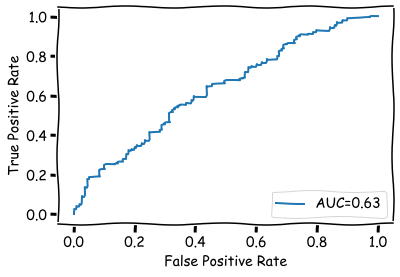

In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_prob_test = modelo_cbt_gr.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_test)
auc = round(metrics.roc_auc_score(y_test, y_prob_test),2)

with plt.xkcd():
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## PF

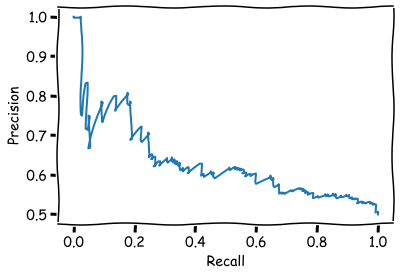

In [17]:
pr = metrics.precision_recall_curve(y_test, y_prob_test)
with plt.xkcd():
    plt.plot(pr[1], pr[0])
    plt.xlabel("Recall")
    plt.ylabel("Precision")

## Variance Importance Factor

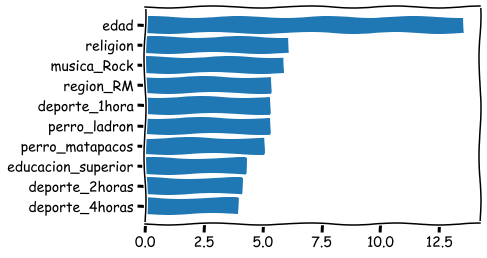

In [18]:
# Variance importance List
vil = pd.DataFrame(list(zip(X_test.columns,modelo_cbt_gr.feature_importances_)),
                   columns=['feature','Feature Importances']
                  ).sort_values(by='Feature Importances', ascending=False)
vil.head()

with plt.xkcd():
    ax = plt.barh(data = vil.sort_values(by='Feature Importances').tail(10), 
             y='feature', 
             width = 'Feature Importances'
            )
    plt.show()